## IMPORTS

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import sys
import cv2
import glob
from IPython.display import clear_output


## DEFINE FUNCTIONS

In [24]:
# def function for storing data in excel file
def store_data_xlsx(data, filepath, sheet_name):
    import openpyxl
    wb = openpyxl.load_workbook(filepath)
    sheet=wb.create_sheet(sheet_name)
    for row in data:
        sheet.append(row)
    wb.save(filepath)
    wb.close()
    print("Data stored in excel file successfully")


In [25]:
# def function for plot the columns with time
def plot_data_time(time_value,column_values, column_names):
    
    # check if the number of columns in column_values and column_names are same
    if len(column_values[0]) != len(column_names):
        print("Number of columns in column_values and column_names are not same")
        return
    # check if the number of rows in time_value and column_values are same
    if len(time_value) != len(column_values):
        print("Number of rows in time_value and column_values are not same")
        return
    
    # plot the data
    plt.figure(figsize=(15,10))
    for i in range(len(column_names)):
        plt.plot(time_value,column_values[:,i],label=column_names[i])
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.legend()
    plt.show()
    print("Plotting done successfully")


In [26]:
# def function for plot the columns one instance of time
def plot_data_instance(df, line, column_names, title, plt):

    # plot the columns 
    ax=sns.barplot(x=df.iloc[line,column_names], y=df.columns[column_names],orient='h')
    
    # add percentages to the bars
    for p in ax.patches:
        width = p.get_width()
        if width>2:
            plt.text(-1.5+p.get_width(), p.get_y()+0.55*p.get_height(),
                        '{:1.1f}%'.format(width),
                        ha='center', va='center',color='white',fontsize=15)
    # if time_colum contains 1 value
    # set the title
    ax.text(0.4, 1.01, title,
            horizontalalignment='center',
            fontsize=20,
            transform = ax.transAxes)

    return ax

In [39]:
# def function to loop over time and plot the data
def plot_data_instances(df, time_ilocs, col_ilocs,
                         x_label="Value ", title0="Time: ",
                           Show=False, number_of_instances="all",
                           extension=".png",dpi=300, directory="plots/"):
    cd0 = os.getcwd()
    # set figure size to 16x9
    sns.set(style="whitegrid")
    sns.set(rc={'figure.figsize':(16,9)})
    sns.set(font_scale=1.5)
    
    xlim_max = np.max(df.iloc[:,col_ilocs].values,axis=(0,1))
    xlim_min = np.min(df.iloc[:,col_ilocs].values,axis=(0,1))
    # set the x limit in the plot
    plt.figure(figsize=(16,9))
    plt.xlim(xlim_min*0.95,xlim_max*1.05)

    # loop over time
    if number_of_instances=="all":
        number_of_instances = len(df.iloc[:,time_ilocs[0]])

    for i in range(number_of_instances):
        
        # plot the data for one instance of time
        title = title0+' \n'.join(df.iloc[i,time_ilocs].values.astype(str))
        ax = plot_data_instance(df, i, col_ilocs, title,plt)
        ax.set(xlabel=x_label)  
        
        # show the plot
        if Show:
            clear_output(wait=True)
            plt.show()
            plt.pause(0.05)
        else:
            #save the plot
            if not os.path.exists(directory):
                os.makedirs(directory)
            filename_save=i
            # save the plot with a good resolution
            plt.savefig(directory+str(filename_save)+extension, dpi=dpi)
            plt.close()
            ax.clear()
        # print progress
        if i%np.floor(number_of_instances/10)==0:
            print("Progress: "+str(np.floor(i*100/number_of_instances))+"%")

    os.chdir(cd0)   
    print("Plotting done successfully")
    

In [42]:
# def function to make video from images
def make_video(image_folder, video_name, fps=20,
                image_extension=".png", video_extension=".mp4",
                number_of_images="all",video_path=os.getcwd()):

    cd0=os.getcwd()
    import cv2
    import glob



    if  number_of_images=="all":
        number_of_images=len(glob.glob(os.path.join(os.getcwd(),image_folder,'*'+image_extension)))
        number_of_images=np.arange(0,number_of_images)
    elif type(number_of_images)==float and number_of_images<1:
        number_of_images=int(len(glob.glob(os.path.join(os.getcwd(),image_folder,'*'+image_extension)))*number_of_images)
        number_of_images=np.arange(0,number_of_images)

    # get size of one of the first images
    img_array = []
    cd_path = os.getcwd()+'/'+image_folder
    img = cv2.imread(os.path.join(cd_path,str(int(number_of_images[0]))+image_extension))
    height1, width1,_ = img.shape
    size1 = (width1,height1)

    print(f"using images from {number_of_images[0]} to {number_of_images[-1]}")
    for i in number_of_images:
        i=int(i)
        img = cv2.imread(os.path.join(cd_path,str(i)+image_extension))
        
        # error handling before resizing
        if img is None:
            print(f"Image not found for {i}")
            return
        # resize the image
        img=cv2.resize(img, size1, interpolation=cv2.INTER_AREA)
        img_array.append(img)

        #print progress
        if i%np.floor(len(glob.glob(os.path.join(os.getcwd(),image_folder,'*'+image_extension)))/10)==0:
            print("Progress: "+str(np.floor(i*100/len(glob.glob(os.path.join(os.getcwd(),image_folder,'*'+image_extension)))))+"%")
            
        # liberate memory
        del img

    # make the video
    video_path = os.path.join(video_path,video_name+video_extension)
    print(f"Saving file {video_path}")
    video = cv2.VideoWriter(video_path,cv2.VideoWriter_fourcc('M','P','4','V'), fps, size1)
    for i in range(len(img_array)):
        # write frame to video
        video.write(img_array[i])
    video.release()
    os.chdir(cd0)
    print("Video made successfully")


In [29]:
# define function that create muliple videos from plots and returns list of videos names to be concatenated
def make_videos(image_folder, fps=24, image_extension=".png", videos_extension=".mp4",
                number_of_videos=5, number_of_images="all", directory="videos/"):
    cd0=os.getcwd()
    
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    print(os.getcwd())

    videos_list = []
    for i in range(number_of_videos):
        video_name = "video"+str(i)

        #  number of images to be used
        if  number_of_images=="all":
            number_of_images=len(glob.glob(os.path.join(os.getcwd(),image_folder,'*'+image_extension)))
        elif type(number_of_images)==float and number_of_images<1:
            number_of_images=int(len(glob.glob(os.path.join(os.getcwd(),image_folder,'*'+image_extension)))*number_of_images)
        else:
            number_of_images=int(number_of_images)

        # number of images to be used for each video
        number_of_instances_video=np.arange(i*np.floor(number_of_images/number_of_videos),(i+1)*np.floor(number_of_images/number_of_videos))
        if i==number_of_videos-1:
            number_of_instances_video=np.arange(i*np.floor(number_of_images/number_of_videos),number_of_images)

        # make video 
        print(f"making video {i} with images from {number_of_instances_video[0]} to {number_of_instances_video[-1]}")
        make_video(image_folder, video_name, fps,
                    image_extension, videos_extension,
                        number_of_instances_video,
                        video_path=os.getcwd()+"/"+directory)
        os.chdir(cd0)
        videos_list.append(video_name)

        # print progress
        if i%np.floor(number_of_videos/10)==0:
            print("Progress: "+str(np.floor(i*100/number_of_videos))+"%")
            
    os.chdir(cd0)
    print("Videos made successfully")   
    return videos_list


In [56]:
# concatenate videos together using imageio
def concatenate_videos(videos_list, concatenated_video_name,
                        video_extension=".mp4",videos_path=os.getcwd()):
    cd0 = os.getcwd()
    import imageio
    videos_list1=[]
    for i in range(len(videos_list)):
        videos_list1.append(os.path.join(videos_path,videos_list[i]+video_extension))
    concatenated_video_name = os.path.join(videos_path,concatenated_video_name+video_extension)
    print(videos_list1,concatenated_video_name)
    reader = imageio.get_reader(videos_list1[0])
    fps = reader.get_meta_data()['fps']
    print(fps)
    writer = imageio.get_writer(concatenated_video_name, fps=fps)
    for video in videos_list1:
        reader = imageio.get_reader(video)
        for im in reader:
            writer.append_data(im)
    writer.close()

    os.chdir(cd0)
    print(f"saving concatenated video to {concatenated_video_name}")
    print("Videos concatenated successfully")


In [31]:
# GLUE SIDE BY SIDE : NOT USED NOW
# use cv2 to glue videos together
def glue_videos_cv2(video1, video2, video_name, video_extension=".avi"):
    # without using moviepy
    import cv2
    import os
    import numpy as np
    
    # get the videos
    cap1 = cv2.VideoCapture(video1+video_extension)
    cap2 = cv2.VideoCapture(video2+video_extension)

    # get the fps
    fps1 = cap1.get(cv2.CAP_PROP_FPS)
    fps2 = cap2.get(cv2.CAP_PROP_FPS)
    print(fps1,fps2)

    # get the size
    width1  = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH))
    height1 = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))
    width2  = int(cap2.get(cv2.CAP_PROP_FRAME_WIDTH))
    height2 = int(cap2.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print(width1,height1,width2,height2)

    # get the codec
    fourcc = cv2.VideoWriter_fourcc(*'XVID')

    # create the video
    out = cv2.VideoWriter(video_name+video_extension,fourcc, min(fps1,fps2), (width1+width2,height1))

    # loop over the frames
    while(cap1.isOpened() and cap2.isOpened()):
        ret1, frame1 = cap1.read()
        ret2, frame2 = cap2.read()
        if ret1==True and ret2==True:
            # write the frame
            out.write(np.concatenate((frame1,frame2),axis=1))
        else:
            break

    # release everything
    cap1.release()
    cap2.release()
    out.release()

    print("Videos glued successfully")
    

## READING & PREPROCCESSING FILE

In [32]:
cd_file="C:\\Users\\azejja\\OneDrive - Alstom\\Bureau\\OwnEndeavors"
filename="Chapter13TablesFigures_taxRevenue_clean.xlsx"
sheetname="Sheet3"
# Reading file
df2=pd.read_excel(os.path.join(cd_file,filename),sheet_name=sheetname,header=0,skipfooter=0)
df2.head()


,Year,Month,Tax Revenue USA,Tax Revenue UK,Tax Revenue Sweden,Tax Revenue France,index
0,1868,Jan,0.0,0.074000,0.0,0.0,0
1,1868,Feb,0.0,0.073875,0.0,0.0,1
2,1868,Mar,0.0,0.073750,0.0,0.0,2
3,1868,Apr,0.0,0.073625,0.0,0.0,3
4,1868,May,0.0,0.073500,0.0,0.0,4


In [33]:
# rename the columns 
df2.rename(columns={'Tax Revenue USA':'USA','Tax Revenue UK':'UK','Tax Revenue Sweden':'Sweden','Tax Revenue France':'France'},inplace=True)

# display the values in %
df2['USA']=df2['USA']*100
df2['UK']=df2['UK']*100
df2['Sweden']=df2['Sweden']*100
df2['France']=df2['France']*100

# column ilocs
col_ilocs=[2,3,4,5]
time_ilocs=[0,1]

#number of nans
print(df2.isnull().sum())
print(df2.head())

Year      0
Month     0
USA       0
UK        0
Sweden    0
France    0
index     0
dtype: int64
   Year Month  USA      UK  Sweden  France  index
0  1868   Jan  0.0  7.4000     0.0     0.0      0
1  1868   Feb  0.0  7.3875     0.0     0.0      1
2  1868   Mar  0.0  7.3750     0.0     0.0      2
3  1868   Apr  0.0  7.3625     0.0     0.0      3
4  1868   May  0.0  7.3500     0.0     0.0      4


## PLOTS

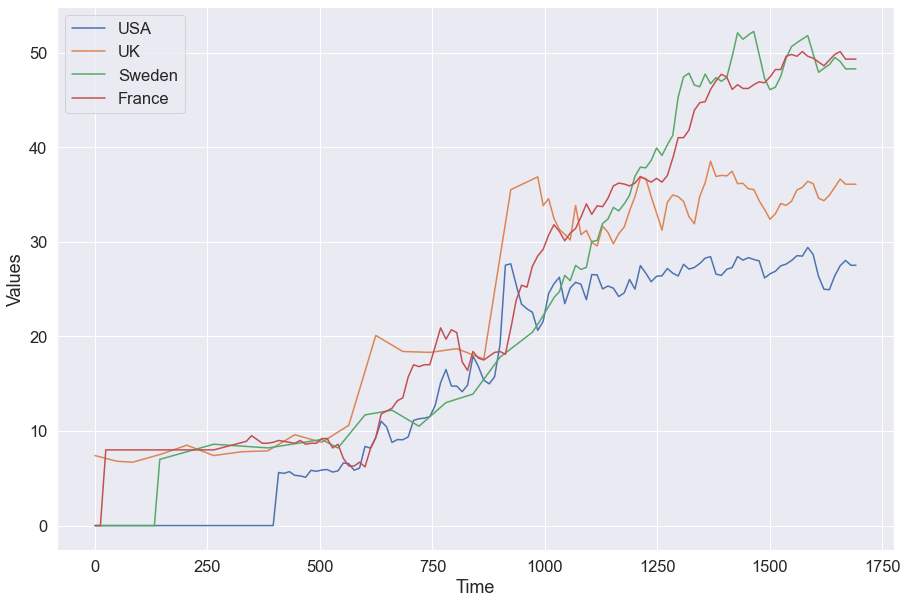

Plotting done successfully


In [34]:
plot_data_time(df2.index.values,df2.values[:,col_ilocs], df2.columns.values[col_ilocs])

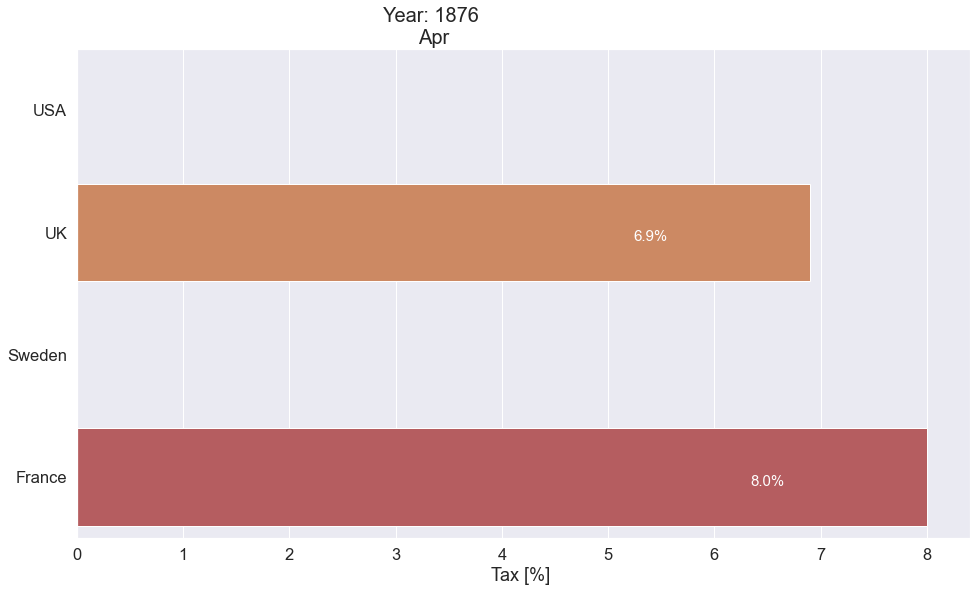

Plotting done successfully


In [37]:
# Showing the plots
plot_data_instances(df2, time_ilocs, col_ilocs=col_ilocs, 
                    x_label="Tax [%] ", title0="Year: ",
                      Show=True, number_of_instances=100,
                      extension=".png",dpi=100, directory="plots/")


In [40]:
# Saving the plots
plot_data_instances(df2, time_ilocs, col_ilocs=col_ilocs, 
                    x_label="Tax [%] ", title0="Year: ",
                      Show=False, number_of_instances="all",
                      extension=".png",dpi=50, directory="plots/")


Progress: 0.0%
Progress: 9.0%
Progress: 19.0%
Progress: 29.0%
Progress: 39.0%
Progress: 49.0%
Progress: 59.0%
Progress: 69.0%
Progress: 79.0%
Progress: 89.0%
Progress: 99.0%
Plotting done successfully


## VIDEO

In [43]:
make_video(image_folder='plots/', video_name='proj2', fps=24,
            image_extension=".png", video_extension=".mp4",
            number_of_images=np.arange(500,1000))


<ipython-input-42-d591053b2e75>:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if  number_of_images=="all":


using images from 500 to 999
Progress: 29.0%
Progress: 39.0%
Progress: 49.0%
Saving file c:\Users\azejja\OneDrive - Alstom\Bureau\OwnEndeavors\proj2.mp4
Video made successfully


In [54]:
videos_directory="videos/"
videos_list=make_videos(image_folder='plots/', fps=24, image_extension=".png", videos_extension=".mp4",
                number_of_videos=5, number_of_images="all", directory=videos_directory)
print(videos_list)

c:\Users\azejja\OneDrive - Alstom\Bureau\OwnEndeavors
making video 0 with images from 0.0 to 337.0
using images from 0.0 to 337.0
Progress: 0.0%


<ipython-input-42-d591053b2e75>:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if  number_of_images=="all":


Progress: 9.0%
Saving file c:\Users\azejja\OneDrive - Alstom\Bureau\OwnEndeavors/videos/video0.mp4
Video made successfully
making video 1 with images from 338.0 to 675.0
using images from 338.0 to 675.0
Progress: 19.0%


<ipython-input-29-92b2aa301f2a>:38: RuntimeWarning: invalid value encountered in double_scalars
  if i%np.floor(number_of_videos/10)==0:


Progress: 29.0%
Saving file c:\Users\azejja\OneDrive - Alstom\Bureau\OwnEndeavors/videos/video1.mp4
Video made successfully
making video 2 with images from 676.0 to 1013.0
using images from 676.0 to 1013.0
Progress: 39.0%


<ipython-input-29-92b2aa301f2a>:38: RuntimeWarning: divide by zero encountered in double_scalars
  if i%np.floor(number_of_videos/10)==0:


Progress: 49.0%
Saving file c:\Users\azejja\OneDrive - Alstom\Bureau\OwnEndeavors/videos/video2.mp4
Video made successfully
making video 3 with images from 1014.0 to 1351.0
using images from 1014.0 to 1351.0
Progress: 59.0%
Progress: 69.0%
Saving file c:\Users\azejja\OneDrive - Alstom\Bureau\OwnEndeavors/videos/video3.mp4
Video made successfully
making video 4 with images from 1352.0 to 1691.0
using images from 1352.0 to 1691.0
Progress: 79.0%
Progress: 89.0%
Progress: 99.0%
Saving file c:\Users\azejja\OneDrive - Alstom\Bureau\OwnEndeavors/videos/video4.mp4
Video made successfully
Videos made successfully
['video0', 'video1', 'video2', 'video3', 'video4']


In [58]:
videos_path=os.getcwd()+'/'+ videos_directory
concatenate_videos(videos_list=videos_list,
                    concatenated_video_name="Concatenated_video",
                        video_extension=".mp4",videos_path=videos_path)
os.chdir(cd_file)

['c:\\Users\\azejja\\OneDrive - Alstom\\Bureau\\OwnEndeavors/videos/video0.mp4', 'c:\\Users\\azejja\\OneDrive - Alstom\\Bureau\\OwnEndeavors/videos/video1.mp4', 'c:\\Users\\azejja\\OneDrive - Alstom\\Bureau\\OwnEndeavors/videos/video2.mp4', 'c:\\Users\\azejja\\OneDrive - Alstom\\Bureau\\OwnEndeavors/videos/video3.mp4', 'c:\\Users\\azejja\\OneDrive - Alstom\\Bureau\\OwnEndeavors/videos/video4.mp4'] c:\Users\azejja\OneDrive - Alstom\Bureau\OwnEndeavors/videos/Concatenated_video.mp4
24.0


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (800, 450) to (800, 464) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


saving concatenated video to c:\Users\azejja\OneDrive - Alstom\Bureau\OwnEndeavors/videos/Concatenated_video.mp4
Videos concatenated successfully


## Using BCR

In [59]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bar_chart_race as bcr

In [60]:
# make a column of Date from Year and month
df2['Date']=pd.to_datetime(df2['Year'].astype(str)+'-'+df2['Month'].astype(str))
# make Date the index
df2.set_index('Date',inplace=True)
df2.head()


,Year,Month,USA,UK,Sweden,France,index
Date,,,,,,,
1868-01-01,1868,Jan,0.0,7.4000,0.0,0.0,0
1868-02-01,1868,Feb,0.0,7.3875,0.0,0.0,1
1868-03-01,1868,Mar,0.0,7.3750,0.0,0.0,2
1868-04-01,1868,Apr,0.0,7.3625,0.0,0.0,3
1868-05-01,1868,May,0.0,7.3500,0.0,0.0,4


In [61]:
os.chdir(cd_file)
bcr.bar_chart_race(
    df2[['USA','UK','Sweden','France']],
    filename="BCR_vid1.mp4",
    img_label_folder="logos",
    fig_kwargs={
        'figsize':(26,15),
        'dpi':120,
        # 'facecolor':'#F8FAFF'
    },
    # n_bars=10,
    steps_per_period=3,
    period_length=20,
    # colors=['#6ECBCE','#FF2243','#FFC33C','#FFA0C4','#B6E836','#FFA0C4','#FFC33C','#FF2243','#6ECBCE','#B6E836'],
    title={'label':'Tax [%] for countries','size':50,'weight':'bold','pad':40},
    period_label={'x':0.95,'y':0.15,'ha':'right','va':'center','size':72,'weight':'semibold'},
    bar_label_font={'size':27},
    tick_label_font={'size':27},
    bar_kwargs={'alpha':.99,'lw':0},
    bar_texttemplate='{x:.2f}',
    period_template='{x:.0f}'
    )


MovieWriter ffmpeg unavailable; using Pillow instead.


Exception: list index out of range